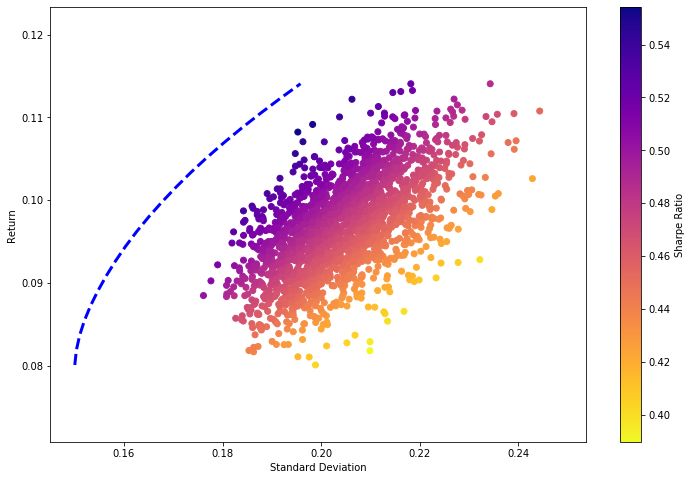

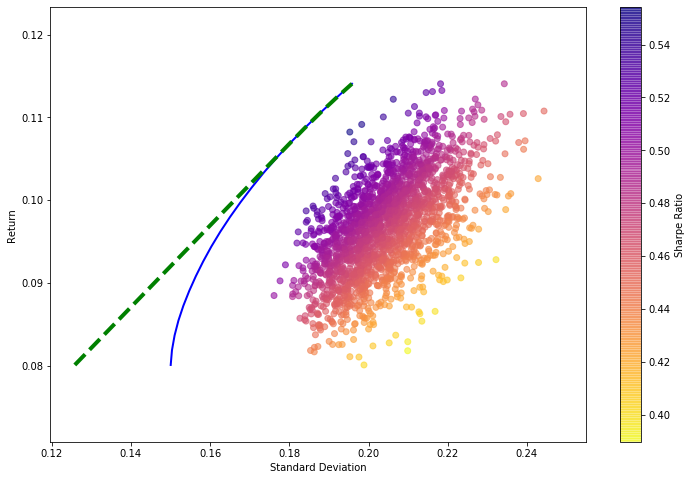

In [41]:
# import packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
from scipy.optimize import minimize


# get adjusted closing prices of selected stocks with yahoo
stocks = ['GOOG', 'NKE', 'LMT', 'CAT' , 'TSLA', 'AMZN', 'TMO' , 'CSIQ' , 'HPE', 'AMD' , 'BHC', 'ROK' , 'TTWO', 'DELL', 'MU']

source = 'yahoo'
start = '2017-01-01'
end = '2019-11-30'


#Retrieve stock price data
data = pd.DataFrame()
for symbol in stocks:
        data[symbol] = pdr.get_data_yahoo(symbol,  start=start, end=end)['Adj Close']
        
data.to_csv('stocks.csv')

#daily historical returns for each stock (S(i) - S(i-1))/ S(i-1)) - use for calculating covariance matrix 
daily_historical_returns = data.pct_change()

#Calculate Returns
#according to Bloomberg’s estimate
#according to yahoo Finance
# betas = []
# for stock in stocks:
    
#     beta = pd.read_html(f'https://ca.finance.yahoo.com/quote/{stock}?p={stock}')[1].iloc[1,1]
#     betas.append(float(beta))

betas = [1.02, 0.83, 0.95, 1.51, 0.58, 1.52, 1.12, 2.04, 1.53, 3.08, 0.89, 1.44, 0.69, 0.74, 1.8]

#risk free interest rate is 1.8% & expected return on the index is 7.8%
risk_free_rate = 1.8 /100
index = 7.8 /100

#calculate the expected return on each stock according to the CAPM pricing model formula
returns = risk_free_rate + np.array(betas) * ( index - risk_free_rate)

#Creating some random portfolios
num_portfolios = 2000

all_weights = np.zeros((num_portfolios,len(stocks)))
ret_arr = np.zeros(num_portfolios)
std_arr = np.zeros(num_portfolios)
sharpe_arr = np.zeros(num_portfolios)


for n in range(num_portfolios):

    # Create Random Weights
    weights = np.array(np.random.random(len(stocks)))

    # Rebalance Weights (sum equal to 1)
    weights = weights / np.sum(weights)
    
    all_weights[n,:] = weights

    # Expected Return
    ret_arr[n] = np.sum(returns * weights)

    # Expected Standard deviation
    std_arr[n] = np.sqrt(np.dot(weights.T, np.dot(daily_historical_returns.cov() * 252, weights)))

    # Sharpe Ratio
    sharpe_arr[n] = ret_arr[n]/std_arr[n]


#Takes in weights, returns array or return,standard deviation, sharpe ratio 
def get_ret_std_sr(weights):

    weights = np.array(weights) 
    port_return = np.sum(returns * weights)
    port_std = np.sqrt(np.dot(weights.T, np.dot(daily_historical_returns.cov() * 252, weights)))
    port_sr = port_return/port_std
    
    return np.array([port_return,port_std,port_sr])

#objective
def minimize_risk(weights):
    return  get_ret_std_sr(weights)[1]

# Initial Guess (equal porportion)
init_guess = [1/len(stocks)] *len(stocks)

# weights boundaries
bounds = tuple((0,1) for asset in range(len(stocks)))

# Create a linspace number of points to calculate x
frontier_returns = np.linspace(min(ret_arr),max(ret_arr),20) 

frontier_std = []

for possible_return in frontier_returns:
    
    # function for finding minimum risk (standard deviation) of any given return
    constraints = ({'type':'eq','fun': lambda w: np.sum(w) - 1},
            {'type':'eq','fun': lambda w: get_ret_std_sr(w)[0] - possible_return})
    
    result = minimize(minimize_risk,init_guess,method='SLSQP',bounds=bounds,constraints=constraints)
    
    frontier_std.append(result['fun'])

plt.figure(figsize=(12,8))
plt.scatter(std_arr,ret_arr,c=sharpe_arr,cmap='plasma_r' )
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Return')

# Add frontier line
plt.plot(frontier_std,frontier_returns,'b--',linewidth=3)
plt.show()


#Portfolio with risk free asset
stocks.append('Risk_Free')

data['Risk_Free'] = risk_free_rate/252

daily_historical_returns = data.pct_change()

returns = np.append(returns , risk_free_rate)

# Initial Guess (equal porportion)
init_guess = [1/len(stocks)] *len(stocks)

# weights boundaries
bounds = tuple((0,1) for asset in range(len(stocks)))

# Create a linspace number of points to calculate x
frontier_returns = np.linspace(min(ret_arr),max(ret_arr),20) 

frontier_std_with_RF = []
weights_frintier = []

for possible_return in frontier_returns:
    
    # function for finding minimum risk (standard deviation) of any given return
    constraints = ({'type':'eq','fun': lambda w: np.sum(w) - 1},
            {'type':'eq','fun': lambda w: get_ret_std_sr(w)[0] - possible_return})
    
    result = minimize(minimize_risk,init_guess,method='SLSQP',bounds=bounds,constraints=constraints)
    
    frontier_std_with_RF.append(result['fun'])
    weights_frintier.append(result['x'])

plt.figure(figsize=(12,8))

plt.scatter(std_arr,ret_arr,c=sharpe_arr,cmap='plasma_r'  , alpha = 0.6)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Return')

# Add frontier line
plt.plot(frontier_std,frontier_returns,'b-',linewidth=2)
plt.plot(frontier_std_with_RF,frontier_returns,'g--',linewidth=4)
plt.show()


plt.figure(figsize=(8,6))

plt.xlabel('Standard Deviation')
plt.ylabel('Return')

# Add frontier line
plt.plot(frontier_std,frontier_returns,'b-',linewidth=2)
plt.plot(frontier_std_with_RF,frontier_returns,'g--',linewidth=4)
plt.show()

results = pd.DataFrame({'return' :frontier_returns, 'risk':frontier_std_with_RF, 'w': weights_frintier} )
w = pd.DataFrame(results['w'].values.tolist(), columns=stocks)
results = results.join(w).drop('w' , axis = 1).round(3)

results.to_csv('results.csv')